In [1]:
import sys
import pandas as pd
import numpy as np
from PIL import Image

from pathlib import Path
from typing import Optional, Dict, Any, Sequence

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

import cv2

from __future__ import annotations
from dataclasses import dataclass

pd.set_option('display.expand_frame_repr', False)  # don't split into blocks
pd.set_option('display.width', 200)               # or None for auto / very wide
pd.set_option('display.max_columns', None)        # show all columns

%pprint on

Pretty printing has been turned OFF


In [2]:
sys.path.append("/kaggle/input/csiro-su/")  # usually not needed, but safe

import importlib, csiro_biomass_shared_utils as csiro_su
importlib.reload(csiro_su)

images_root_dir = "/kaggle/input/csiro-biomass-images/"
data_root_dir   = "/kaggle/input/csiro-biomass-data/"

def load_split_dfs(in_dir="dataset/"):
    in_dir = Path(in_dir)

    train_df = pd.read_parquet(in_dir / "train.parquet")
    val_df   = pd.read_parquet(in_dir / "val.parquet")
    test_df  = pd.read_parquet(in_dir / "test.parquet")

    return train_df, val_df, test_df

train_df, val_df, test_df = load_split_dfs(data_root_dir)
print(len(train_df), len(val_df), len(test_df))
print(len(train_df.columns), len(val_df.columns), len(test_df.columns))

255 50 51
21 21 21


In [3]:
BIOMASS_COLS = ["Dry_Clover_g","Dry_Dead_g","Dry_Green_g","Dry_Total_g","GDM_g"]
BIOMASS_W    = [0.1, 0.1, 0.1, 0.5, 0.2]

# ---------- small helpers ----------
def _to_float(x):
    try:
        return float(x)
    except Exception:
        return float("nan")

def make_id2species(species2id: dict):
    """
    species2id: {species_name: int_id}
    returns: list where id2species[id] = species_name
    """
    max_id = max(species2id.values())
    id2 = [""] * (max_id + 1)
    for name, sid in species2id.items():
        id2[sid] = name
    return id2

def compute_tail_q_from_train_df(train_df: pd.DataFrame, target_cfg: dict, stats: dict, qs=(0.90, 0.99), eps: float = 1e-8):
    tail_q = {}

    for col, cfg in target_cfg.items():
        s = pd.to_numeric(train_df[col], errors="coerce")  # Series with NaNs possible

        # 1) log1p (if configured)
        if cfg.get("log1p", False):
            s = np.log1p(np.clip(s.values.astype(np.float32), 0.0, None))
        else:
            s = s.values.astype(np.float32)

        # 2) normalize (if configured)
        if cfg.get("normalize", True):
            mu, sigma = stats[col]
            sigma = float(sigma) if float(sigma) > eps else eps
            s = (s - float(mu)) / sigma

        # 3) quantiles (ignore NaNs)
        qvals = np.nanquantile(s, qs)

        tail_q[col] = {f"q{int(q*100)}": float(v) for q, v in zip(qs, qvals)}

    return tail_q

def col_mean_std_from_series(s: pd.Series, ddof: int = 0, eps: float = 1e-8):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if len(s) == 0:
        raise ValueError("No valid numeric values to compute mean/std.")
    mu = float(s.mean())
    sigma = float(s.std(ddof=ddof))
    if (not np.isfinite(sigma)) or sigma < eps:
        sigma = eps
    return mu, sigma

class Image2BiomassData(Dataset):
    def __init__(self, dataframe: pd.DataFrame, images_dir: str,
                 mode: str = "train", export_state: bool = False,
                 import_state: bool = False, state: dict | None = None):

        self.df                 = dataframe.reset_index(drop=True).copy()
        self.images_dir         = images_dir
        self.mode               = mode
        self.stats              = {}
        self.species_wsst       = None
        self.id2species         = None
        self.tail_q             = None
        
        # fixed columns (no extra init args)
        # sample_id Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g GDM_g
        # SpeciesBucket Tbin Gbin Dbin Cbin Rbin  GroupID  TailFlag  StratifyKey StratifyKey_safe
        self.id_col         = "sample_id"
        self.species_col    = "Species"
        self.numeric_cols   = ["Pre_GSHH_NDVI", "Height_Ave_cm", "Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]
        self.meta_cols      = ["SpeciesBucket", "Tbin", "Gbin", "Dbin", "Cbin", "Rbin", "GroupID", "TailFlag", "StratifyKey", "StratifyKey_safe"]
     
        # Decide per-column transform (example)
        self.target_cfg = {
            "Pre_GSHH_NDVI": {"log1p": False, "normalize": True},
            "Height_Ave_cm": {"log1p": True,  "normalize": True},
            "Dry_Clover_g":  {"log1p": True,  "normalize": True},
            "Dry_Dead_g":    {"log1p": True,  "normalize": True},
            "Dry_Green_g":   {"log1p": True,  "normalize": True},
            "Dry_Total_g":   {"log1p": True,  "normalize": True},
            "GDM_g":         {"log1p": True,  "normalize": True},
        }
        
        # ---- IMPORT STATE (no refit) ----
        if import_state:
            if state is None:
                raise ValueError("import_state=True requires a non-None `state`.")
            self.stats          = state["stats"]
            self.species2id = state["species2id"]
            self.target_cfg = state.get("target_cfg", self.target_cfg)
            self.tail_q      = state.get("tail_q", None)
            self.id2species   = state.get("id2species", None)
            if self.id2species is None:
                self.id2species = make_id2species(self.species2id)

        else:
            # ---- FIT ON THIS DATAFRAME (train) ----
            # species mapping (fit from provided dataframe)
            uniq = sorted(self.df[self.species_col].astype(str).unique().tolist())
            self.species2id = {"__UNK__": 0, **{s: i + 1 for i, s in enumerate(uniq)}}
            
            self.id2species = make_id2species(self.species2id)
            
            # 1) fit stats (needed for normalization)
            for col, cfg in self.target_cfg.items():
                s = pd.to_numeric(self.df[col], errors="coerce")
                if cfg.get("log1p", False):
                    # log1p requires x >= -1; for biomass it should be >= 0
                    s = np.log1p(np.clip(s, 0, None))
                mu, sigma = col_mean_std_from_series(s)
                self.stats[col] = (mu, sigma)
            
            # 2) compute tail quantiles on transformed+standardized scale
            self.tail_q = compute_tail_q_from_train_df(self.df, self.target_cfg, self.stats,
                                                       qs=[0.50, 0.75, 0.90, 0.95, 0.99])
            
        # ---- optionally store exportable state ----
        self._state = self.get_state() if export_state else None
        
        IMAGENET_MEAN = [0.485, 0.456, 0.406]
        IMAGENET_STD  = [0.229, 0.224, 0.225]

        # optional torch versions (handy for unnormalize)
        IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3,1,1)
        IMAGENET_STD_T  = torch.tensor(IMAGENET_STD).view(3,1,1)

        # build image tfms ONCE (do not recreate per sample)
        TARGET_H, TARGET_W = 256, 512
        if self.mode == "train":
            self.img_tfms = T.Compose([
                T.ToTensor(),
                T.Resize((TARGET_H, TARGET_W), interpolation=InterpolationMode.BICUBIC),

                T.RandomHorizontalFlip(p=0.5),
                T.RandomVerticalFlip(p=0.5),

                T.RandomApply([T.RandomRotation(
                    degrees=5,
                    interpolation=InterpolationMode.BILINEAR,
                    fill=0
                )], p=0.25),

                T.RandomApply([T.ColorJitter(
                    brightness=0.2, contrast=0.2, saturation=0.15, hue=0.03
                )], p=0.25),

                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ])
        else:
            self.img_tfms = T.Compose([
                T.ToTensor(),
                T.Resize((TARGET_H, TARGET_W), interpolation=InterpolationMode.BICUBIC),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ])

    def get_state(self) -> dict:
        return {
            "stats"         : self.stats,
            "species2id"    : self.species2id,
            "id2species"    : self.id2species,
            "target_cfg"    : self.target_cfg,
            "tail_q"        : self.tail_q,
            "bio5_cols"     : BIOMASS_COLS,
            "bio5_w"        : BIOMASS_W
        }
            
    def _transform_and_standardize(self, col: str, x: float) -> float:
        cfg = self.target_cfg[col]

        # 1) transform
        if cfg.get("log1p", False):
            x = np.log1p(max(x, 0.0))

        # 2) optional standardization
        if cfg.get("normalize", True):
            mu, sigma = self.stats[col]
            x = (x - mu) / sigma

        return float(x)

    def __len__(self):
        return len(self.df)

    def _img_path(self, sid: str) -> Path:
        return f"{self.images_dir}/{sid}.jpg"

    def _transform_image(self, img_path: Path) -> torch.Tensor:
        img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise FileNotFoundError(f"Image not found or unreadable: {img_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return self.img_tfms(img_rgb)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        ## -- Get the right index ---
        row = self.df.iloc[idx]
        sid = str(row[self.id_col])
        
        img_t = self._transform_image(f"{self.images_dir}/{sid}.jpg")
        
        out = {"img_t": img_t}
        
        ## -- sample_id : nothing changes --
        out.update({ "sample_id": sid})
       
        # species -> id (use precomputed mapping)
        sp = str(row[self.species_col])
        sp_id = self.species2id.get(sp, self.species2id["__UNK__"])
        out["species_id"] = torch.tensor(sp_id, dtype=torch.long)
        
        ## All the remaining columns:
        # Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g GDM_g
        for c in self.target_cfg.keys():
            out[c] = torch.tensor(self._transform_and_standardize(c, _to_float(row[c])), dtype=torch.float32)
                
        # copy remaining/meta columns AS-IS (no transforms)
        for k in self.meta_cols:
            if k in row.index:
                out[k] = row[k]
                
        # pack y = [NDVI, Height, Clover, Dead, Green, Total, GDM]
        out["y"] = torch.stack([
            out["Pre_GSHH_NDVI"],
            out["Height_Ave_cm"],
            out["Dry_Clover_g"],
            out["Dry_Dead_g"],
            out["Dry_Green_g"],
            out["Dry_Total_g"],
            out["GDM_g"],
        ], dim=0)  # (7,)
        
        # unified 5-d biomass target (transformed/standardized space)
        out["bio5"] = torch.stack([
            out["Dry_Clover_g"],
            out["Dry_Dead_g"],
            out["Dry_Green_g"],
            out["Dry_Total_g"],
            out["GDM_g"],
        ], dim=0)  # (5,)
            
        return out


In [4]:
import pprint
pp = pprint.PrettyPrinter(width=140, compact=False, sort_dicts=False)

train_ds = Image2BiomassData(train_df, f"{images_root_dir}/images", mode="train", export_state=True)
state = train_ds.get_state()
# pp.pprint(state)

val_ds = Image2BiomassData(val_df, f"{images_root_dir}/images", mode="val", import_state=True, state=state)
state = val_ds.get_state()
# pp.pprint(state)

test_ds = Image2BiomassData(test_df, f"{images_root_dir}/images", mode="val", import_state=True, state=state)
state = val_ds.get_state()
# pp.pprint(state)

In [5]:
BATCH_SIZE = 1

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

b = next(iter(train_dl))
print("img_t:", b["img_t"].shape, b["img_t"].dtype)
print("y:", b["y"].shape, b["y"].dtype)
print("species_id:", b["species_id"].shape, b["species_id"].dtype)
print("sample_id:", len(b["sample_id"]), b["sample_id"][0])

state = train_ds.get_state()
species2id = state["species2id"]
print(species2id)

img_t: torch.Size([1, 3, 256, 512]) torch.float32
y: torch.Size([1, 7]) torch.float32
species_id: torch.Size([1]) torch.int64
sample_id: 1 ID121331988
{'__UNK__': 0, 'Clover': 1, 'Fescue': 2, 'Fescue_CrumbWeed': 3, 'Lucerne': 4, 'Mixed': 5, 'Phalaris': 6, 'Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed': 7, 'Phalaris_Clover': 8, 'Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass': 9, 'Phalaris_Ryegrass_Clover': 10, 'Ryegrass': 11, 'Ryegrass_Clover': 12, 'SubcloverDalkeith': 13, 'SubcloverLosa': 14, 'WhiteClover': 15}


In [6]:
# ## The model

import torch
import torch.nn as nn 
import torchvision.models as models

class ResNetBackbone(nn.Module):
    def __init__(self, pretrained: bool = True):
        super().__init__()
        
        if pretrained:
            w = models.ResNet18_Weights.DEFAULT
        else:
            w = None
        
        # use resnet18 instead of resnet34
        m = models.resnet18(weights=w)

        # ResNet stem + layers
        self.conv1   = m.conv1
        self.bn1     = m.bn1
        self.relu    = m.relu
        self.maxpool = m.maxpool
        self.layer1  = m.layer1
        self.layer2  = m.layer2
        self.layer3  = m.layer3   # "higher" features
        self.layer4  = m.layer4   # final features
        self.avgpool = m.avgpool

        # use the **last** block in each layer so it works for 18/34/etc.
        self.out_dim_layer2 = m.layer2[-1].bn2.num_features
        self.out_dim_layer3 = m.layer3[-1].bn2.num_features
        self.out_dim_final  = m.fc.in_features  # 512 for resnet18
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x      = self.layer1(x)
        feat_l2 = self.layer2(x)
        feat_l3 = self.layer3(feat_l2)
        feat_l4 = self.layer4(feat_l3)

        # global pooling for final features
        f_final = self.avgpool(feat_l4)
        f_final = torch.flatten(f_final, 1)  # (B, 512)

        return feat_l2, feat_l3, f_final

class Image2BiomassModel(nn.Module):
    def __init__(self, num_species, pretrained=True):
        super().__init__()
        
        self.backbone = ResNetBackbone(pretrained=pretrained)
        
        out_l2 = self.backbone.out_dim_layer2
        out_l3 = self.backbone.out_dim_layer3
        out_final = self.backbone.out_dim_final
        # self.register_buffer("w_species", torch.ones(num_species, dtype=torch.float32))

   
        def make_head_species(out_dim):
            return nn.Sequential(
                nn.Linear(in_features=out_final, out_features=256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2), #
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )
            
        def make_head_ndvi(out_dim):
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )
        
        def make_head_height(out_dim):
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2), # 
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2), # 
                nn.Linear(128, out_dim)
            )
            
        def make_head_biomass(out_dim):
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2), # 
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )
        
        def make_head_clover_p(out_dim):
            # Clover presence (binary) -> output is a logit (no sigmoid here)
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )

        def make_head_clover_mag(out_dim):
            # Clover magnitude (regression) -> predict same space as y (standardized log1p)
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )

        
        # custome heads for Image2BiomassModel
        self.head_species = make_head_species(num_species)      # Classfication
        self.head_ndvi    = make_head_ndvi(1)                   # Regression
        self.head_height  = make_head_height(1)                 # Regression
        self.head_biomass    = make_head_biomass(5)             # Clover, Dead, Green, Total, GDM

        
        # ---- Optional uncertainty weighting (Kendall & Gal style) ----
        # Toggle this externally: model.use_uncertainty = True/False
        self.use_uncertainty = False

        # One log-variance per task loss you combine:
        # [species, ndvi, height, biomass]
        # Start at 0 => exp(-s)=1, so it behaves like an unweighted sum initially.
        self.log_vars = nn.Parameter(torch.zeros(4))

    
    def enable_uncertainty(self, enabled: bool = True):
        self.use_uncertainty = bool(enabled)
        return self

    def uncertainty_weights(self):
        # returns exp(-s) as a detached tensor for logging
        return torch.exp(-self.log_vars.detach())

    def forward(self, x):
        out_l2, out_l3, f_final = self.backbone(x)              # IN: torch.Size([1, 3, 256, 512]) -> OUT:
        
        out = {
            "species"   : self.head_species(f_final),                  # (B,C)
            "ndvi"      : self.head_ndvi(f_final).squeeze(-1),         # (B,)
            "height"    : self.head_height(f_final).squeeze(-1),       # (B,)
            "biomass"   : self.head_biomass(f_final),                  # (B,5)
        }
        
        return out

In [7]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state = train_ds.get_state()
num_species = len(state["species2id"])
img2bm_model = Image2BiomassModel(num_species=num_species, pretrained=True).to(device)

img2bm_model.enable_uncertainty(False)   # ON

backbone_params = []
log_s_params = []
species_params, ndvi_params, height_params, biomass_head_params = [], [], [], []

for name, p in img2bm_model.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("backbone."):
        backbone_params.append(p)
    elif name.startswith("head_species."):
        species_params.append(p)
    elif name.startswith("head_ndvi."):
        ndvi_params.append(p)
    elif name.startswith("head_height."):
        height_params.append(p)
    elif name.startswith("head_biomass."):
        biomass_head_params.append(p)
    elif name.startswith("log_s_"):
        log_s_params.append(p)
    else:
        # if anything unexpected appears
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params,      "lr": 1e-4, "weight_decay": 0.0},
        {"params": species_params,       "lr": 1e-4, "weight_decay": 0.0},
        {"params": ndvi_params,          "lr": 1e-4, "weight_decay": 0.0},
        {"params": height_params,        "lr": 1e-4, "weight_decay": 0.0},
        {"params": biomass_head_params,  "lr": 1e-4, "weight_decay": 0.0},
        {"params": log_s_params,         "lr": 1e-4, "weight_decay": 0.0},
    ]
)
      
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    factor=0.7,
    patience=3, # 7
    threshold=0.01, # .005
    min_lr=1e-7,
    threshold_mode='abs'
)

id2 = state["id2species"]
for sid, name in enumerate(id2):
    print(sid, name)
    # print(sid, name, float(img2bm_model.w_species[sid]))

0 __UNK__
1 Clover
2 Fescue
3 Fescue_CrumbWeed
4 Lucerne
5 Mixed
6 Phalaris
7 Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed
8 Phalaris_Clover
9 Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass
10 Phalaris_Ryegrass_Clover
11 Ryegrass
12 Ryegrass_Clover
13 SubcloverDalkeith
14 SubcloverLosa
15 WhiteClover


In [8]:
import torch.nn.functional as F
import torch

BIOMASS_WEIGHTS = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.2])  # Clover, Dead, Green, Total, GDM
# BIOMASS_WEIGHTS_LOSSES = torch.tensor([0.5, 0.5, 1.0, 3.0, 2.0])  # Clover, Dead, Green, Total, GDM

def smooth_l1(x, y, beta=1.0, reduction="none"):
    return F.smooth_l1_loss(x, y, beta=beta, reduction=reduction)


def _inv_transform(col: str, x: torch.Tensor, state: dict) -> torch.Tensor:
    """
    x: tensor on standardized (and maybe log1p) scale -> returns raw scale tensor
    """
    stats = state["stats"]
    cfg   = state.get("target_cfg", {})

    mu, sig = stats[col]
    x = x * sig + mu

    if cfg.get(col, {}).get("log1p", False):
        x = torch.expm1(x)
        x = torch.clamp(x, min=0.0)

    return x

def ramp_weight(epoch, max_epoch, start=0.3, end=1.0, power=2.0):
    """
    Returns a scalar in [start, end], increasing over training.
    power > 1 makes it increase slowly early, faster later.
    """
    t = 0.0 if max_epoch is None else float(epoch) / float(max_epoch)
    t = max(0.0, min(1.0, t))
    r = t ** power
    return start + (end - start) * r

def BIO_LOSS_FN(bio_hat5, bio_true5, weights=None):
    """
    Compute weighted MSE loss for biomass (5 components).
    
    bio_hat5, bio_true5: (B, 5) tensors
    weights: (5,) or None. If None, uses equal weighting.
    """
    device = bio_hat5.device
    dtype = bio_hat5.dtype
    
    if weights is None:
        # Equal weighting
        mse_per_dim = ((bio_hat5 - bio_true5) ** 2).mean(dim=0)  # (5,)
        return mse_per_dim.mean()  # scalar
    else:
        # Normalize weights to sum to 1
        w = weights.to(device=device, dtype=dtype)
        w_norm = w / (w.sum() + 1e-12)
        
        # Weighted MSE
        mse_per_dim = ((bio_hat5 - bio_true5) ** 2).mean(dim=0)  # (5,)
        return (w_norm * mse_per_dim).sum()  # scalar

def multitask_losses(model, preds, targets, 
                     task_weights=None,
                     biomass_component_weights=None):
    """
    Compute multi-task loss with optional task weighting and biomass component weighting.
    
    task_weights: dict with keys ["species", "ndvi", "height", "biomass"] 
                  or None for equal weighting. Will be normalized to sum to 1.
    biomass_component_weights: (5,) tensor for [Clover, Dead, Green, Total, GDM]
                               or None for equal weighting.
    """
    anchor = preds["biomass"]
    device = anchor.device
    dtype  = anchor.dtype
    
    species_true = targets["species_id"].long().view(-1)      # (B,)
    bio_true5    = targets["bio5"].to(preds["biomass"].device)  # (B,5)
    # ---- targets (for ndvi/height) ----
    y_true      = targets["y"].to(device=device, dtype=dtype)          # (B,7) if you still pass it
    ndvi_true   = y_true[:, 0]
    height_true = y_true[:, 1]

    # ---- predictions ----
    species_logits = preds["species"]   # (B,C)
    ndvi_hat       = preds["ndvi"]      # (B,)
    height_hat     = preds["height"]    # (B,)
    bio_hat5       = preds["biomass"]   # (B,5)

    # ---- basic losses ----
    loss_species = F.cross_entropy(species_logits, species_true, label_smoothing=0.05)
    loss_ndvi    = F.mse_loss(ndvi_hat, ndvi_true)
    loss_height  = F.smooth_l1_loss(height_hat, height_true)

    # ---- biomass loss with component weighting ----
    loss_biomass = BIO_LOSS_FN(bio_hat5, bio_true5, weights=biomass_component_weights)

    # ---- optional task weighting ----
    if task_weights is None:
        # Equal weighting: each loss contributes equally
        task_weights = {"species": 1.0, "ndvi": 1.0, "height": 1.0, "biomass": 1.0}
    
    # Normalize task weights to sum to 1 (so total loss scale is meaningful)
    w_sum = sum(task_weights.values())
    w_norm = {k: v / (w_sum + 1e-12) for k, v in task_weights.items()}
    
    total_loss = (w_norm["species"] * loss_species + 
                  w_norm["ndvi"]    * loss_ndvi    + 
                  w_norm["height"]  * loss_height  + 
                  w_norm["biomass"] * loss_biomass)

    return total_loss, {
        "species": loss_species.detach(),
        "ndvi": loss_ndvi.detach(),
        "height": loss_height.detach(),
        "biomass": loss_biomass.detach(),
    }


# same order as dataset bio5: [Clover, Dead, Green, Total, GDM]
BIOMASS_WEIGHTS = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.2], dtype=torch.float32)

@torch.inference_mode()
def multitask_accuracies(preds, targets):
    """
    Monitoring metrics (NOT used for backprop):
      - species: classification accuracy
      - ndvi/height/biomass: "score" = 1/(1+mse)
        (higher is better, bounded in (0,1])
    Expects:
      preds: dict with keys ["species","ndvi","height","biomass"] where biomass is (B,5)
      targets: dict with keys ["y","bio5","species_id"]
        y is (B,7): [NDVI, Height, Clover, Dead, Green, Total, GDM]
        bio5 is (B,5): [Clover, Dead, Green, Total, GDM]
    """
    device = preds["biomass"].device
    dtype  = preds["biomass"].dtype

    # ---- preds ----
    species_logits = preds["species"]                 # (B,C)
    ndvi_hat       = preds["ndvi"]                    # (B,)
    height_hat     = preds["height"]                  # (B,)
    bio_hat5       = preds["biomass"]                 # (B,5)

    # ---- targets ----
    species_true = targets["species_id"].long().to(device)        # (B,)
    y_true       = targets["y"].to(device=device, dtype=dtype)     # (B,7)
    ndvi_true    = y_true[:, 0]
    height_true  = y_true[:, 1]
    bio_true5    = targets["bio5"].to(device=device, dtype=dtype)  # (B,5)

    # --- species accuracy ---
    species_acc = (species_logits.argmax(dim=1) == species_true).float().mean()

    # --- helper mse -> score ---
    def err_to_score(mse):
        return 1.0 / (1.0 + mse)

    # --- ndvi / height mse ---
    ndvi_mse   = F.mse_loss(ndvi_hat, ndvi_true)
    height_mse = F.mse_loss(height_hat, height_true)

    # --- biomass weighted mse across 5 dims ---
    bw = BIOMASS_WEIGHTS.to(device=device, dtype=dtype)
    bw = bw / (bw.sum() + 1e-12)  # normalize sum=1 for stability

    mse_per_dim = ((bio_hat5 - bio_true5) ** 2).mean(dim=0)         # (5,)
    biomass_mse = (bw * mse_per_dim).sum()                           # scalar

    return {
        "species": species_acc,
        "ndvi":    err_to_score(ndvi_mse),
        "height":  err_to_score(height_mse),
        "biomass": err_to_score(biomass_mse),
    }


In [9]:
import torch

BIOMASS_COLS = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]
BIOMASS_W    = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.2], dtype=torch.float64)  # matches cols above

def _inv_transform(col: str, x: torch.Tensor, state: dict) -> torch.Tensor:
    """
    x: tensor on standardized (and maybe log1p) scale -> returns raw scale tensor
    """
    stats = state["stats"]
    cfg   = state.get("target_cfg", {})

    mu, sig = stats[col]
    x = x * sig + mu

    if cfg.get(col, {}).get("log1p", False):
        x = torch.expm1(x)
        x = torch.clamp(x, min=0.0)

    return x

@torch.inference_mode()
def compute_biomass_r2_components_raw_with_breakdown(
    model,
    data_loader,
    device,
    state,
    eps: float = 1e-12,
):
    """
    Computes weighted R2 (r2_w) for the 5 biomass components in RAW space:
      [Dry_Clover_g, Dry_Dead_g, Dry_Green_g, Dry_Total_g, GDM_g]
    """
    model.eval()

    all_pred_raw = []
    all_true_raw = []

    for batch in data_loader:
        images = batch["img_t"].to(device)
        y_true = batch["y"].to(device)  # (B,7) transformed

        preds = model(images)

        # y layout: [NDVI, Height, Clover, Dead, Green, Total, GDM]
        y_true_bio5 = y_true[:, 2:7]      # (B,5) -> [Clover, Dead, Green, Total, GDM]
        bio_hat5    = preds["biomass"]    # (B,5) -> [Clover, Dead, Green, Total, GDM]

        # ---- preds -> raw ----
        clover_raw_hat = _inv_transform("Dry_Clover_g", bio_hat5[:, 0], state).clamp_min(0.0)
        dead_raw_hat   = _inv_transform("Dry_Dead_g",   bio_hat5[:, 1], state).clamp_min(0.0)
        green_raw_hat  = _inv_transform("Dry_Green_g",  bio_hat5[:, 2], state).clamp_min(0.0)
        total_raw_hat  = _inv_transform("Dry_Total_g",  bio_hat5[:, 3], state).clamp_min(0.0)
        gdm_raw_hat    = _inv_transform("GDM_g",        bio_hat5[:, 4], state).clamp_min(0.0)

        y_pred_raw = torch.stack(
            [clover_raw_hat, dead_raw_hat, green_raw_hat, total_raw_hat, gdm_raw_hat],
            dim=1
        )  # (B,5)

        # ---- truths -> raw ----
        clover_raw_true = _inv_transform("Dry_Clover_g", y_true_bio5[:, 0], state).clamp_min(0.0)
        dead_raw_true   = _inv_transform("Dry_Dead_g",   y_true_bio5[:, 1], state).clamp_min(0.0)
        green_raw_true  = _inv_transform("Dry_Green_g",  y_true_bio5[:, 2], state).clamp_min(0.0)
        total_raw_true  = _inv_transform("Dry_Total_g",  y_true_bio5[:, 3], state).clamp_min(0.0)
        gdm_raw_true    = _inv_transform("GDM_g",        y_true_bio5[:, 4], state).clamp_min(0.0)

        y_true_raw = torch.stack(
            [clover_raw_true, dead_raw_true, green_raw_true, total_raw_true, gdm_raw_true],
            dim=1
        )  # (B,5)

        all_pred_raw.append(y_pred_raw.detach().cpu())
        all_true_raw.append(y_true_raw.detach().cpu())

    y_pred = torch.cat(all_pred_raw, dim=0).to(torch.float64)  # (N,5)
    y_true = torch.cat(all_true_raw, dim=0).to(torch.float64)  # (N,5)

    N = y_true.shape[0]

    # weights for the 5 biomass components
    w = BIOMASS_W.to(dtype=y_true.dtype).view(1, -1)  # (1,5)
    w_mat = w.expand_as(y_true)                       # (N,5)

    # ---- per-component SS_res ----
    ss_res_by_col = (w_mat * (y_true - y_pred) ** 2).sum(dim=0)  # (5,)

    # ---- SS_tot (uses global weighted mean) ----
    y_bar_w = (w_mat * y_true).sum() / (w_mat.sum() + eps)       # scalar
    ss_tot_by_col = (w_mat * (y_true - y_bar_w) ** 2).sum(dim=0) # (5,)

    # ---- global totals ----
    ss_res = ss_res_by_col.sum()
    ss_tot = ss_tot_by_col.sum()
    r2_w = 1.0 - ss_res / (ss_tot + eps)

    cols = list(BIOMASS_COLS)

    breakdown = {
        "cols": cols,

        "ss_res_by_col": ss_res_by_col.tolist(),
        "ss_tot_by_col": ss_tot_by_col.tolist(),

        "ss_res_by_col_per_sample": (ss_res_by_col / (N + eps)).tolist(),
        "ss_tot_by_col_per_sample": (ss_tot_by_col / (N + eps)).tolist(),

        "ss_res_pct": (100.0 * ss_res_by_col / (ss_res + eps)).tolist(),
        "ss_tot_pct": (100.0 * ss_tot_by_col / (ss_tot + eps)).tolist(),

        "ss_res_by_col_dict": {cols[i]: ss_res_by_col[i].item() for i in range(len(cols))},
        "ss_tot_by_col_dict": {cols[i]: ss_tot_by_col[i].item() for i in range(len(cols))},
    }

    return {
        "ss_res": ss_res.item(),
        "ss_tot": ss_tot.item(),
        "r2_w":  r2_w.item(),
        "breakdown": breakdown,
    }


In [10]:
def train_one_epoch(model, optimizer, train_dl, tail_q=None, stats=None, epoch=None, max_epoch=None, 
                    device=torch.device("cuda"), task_weights=None, biomass_component_weights=None):
    model.train()

    total = 0
    running_loss = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}
    running_acc  = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}

    for batch in train_dl:
        optimizer.zero_grad(set_to_none=True)

        images    = batch["img_t"].to(device, non_blocking=True)
        y_true    = batch["y"].to(device, non_blocking=True)              # (B,7)
        sp_true   = batch["species_id"].to(device, non_blocking=True)      # (B,)
        bio5_true = batch["bio5"].to(device, non_blocking=True)            # (B,5)

        targets = {"y": y_true, "species_id": sp_true, "bio5": bio5_true}

        preds = model(images)

        total_loss, loss_parts = multitask_losses(
            model, preds, targets,
            task_weights=task_weights,
            biomass_component_weights=biomass_component_weights
        )

        total_loss.backward()
        optimizer.step()

        bs = images.size(0)
        total += bs

        with torch.inference_mode():
            batch_acc = multitask_accuracies(preds, targets)
            for k in running_loss:
                running_loss[k] += loss_parts[k].item() * bs
                running_acc[k]  += batch_acc[k].item() * bs

    return {k: v/total for k, v in running_loss.items()}, {k: v/total for k, v in running_acc.items()}



def eval_one_epoch(model, eval_dl, stats=None, epoch=None, max_epoch=None, 
                   device=torch.device("cuda"), task_weights=None, biomass_component_weights=None):
    model.eval()

    total = 0
    running_loss = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}
    running_acc  = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}

    with torch.inference_mode():
        for batch in eval_dl:
            images    = batch["img_t"].to(device, non_blocking=True)
            y_true    = batch["y"].to(device, non_blocking=True)
            species_id = batch["species_id"].to(device, non_blocking=True)
            bio5_true  = batch["bio5"].to(device, non_blocking=True)   # <-- NEW

            targets = {"y": y_true, "species_id": species_id, "bio5": bio5_true}  # <-- UPDATED

            preds = model(images)

            total_loss, loss_parts = multitask_losses(
                model, preds, targets,
                task_weights=task_weights,
                biomass_component_weights=biomass_component_weights
            )

            bs = images.size(0)
            total += bs

            batch_acc = multitask_accuracies(preds, targets)
            for k in running_loss:
                running_loss[k] += loss_parts[k].item() * bs
                running_acc[k]  += batch_acc[k].item() * bs

    return {k: v/total for k, v in running_loss.items()}, {k: v/total for k, v in running_acc.items()}



# [Epoch 01/25]:Train loss: species:2.4264, ndvi:0.5508, height:0.6323, biomass:1.2123
def fmt_metrics(d, factor=1.0, precision=4):
    return ", ".join(f"{k[:2]}:{factor * float(v):3.{precision}f}" for k, v in d.items())


def fit(model, optimizer=optimizer, sched=None, train_dl=None, valid_dl=None,
        epochs=25, verbose_every=5, device=torch.device("cuda"), state=None,
        task_weights=None, biomass_component_weights=None):

    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": [],
               "val_comp": [], "lr": [], "r2_comp": []}

    # Always use train dataset state as source of truth
    state = train_dl.dataset.get_state()
    stats = state["stats"]
    tail_q = state["tail_q"]
    
    # Default task weights (biomass gets 2x weight since it's the main objective)
    if task_weights is None:
        task_weights = {"species": 0.5, "ndvi": 1.0, "height": 1.0, "biomass": 2.0}
    
    # Default biomass component weights
    if biomass_component_weights is None:
        biomass_component_weights = BIOMASS_WEIGHTS.clone()

    max_epoch = epochs + 1
    for ep in range(1, max_epoch):
        train_losses, train_accs = train_one_epoch(
            model, optimizer=optimizer, train_dl=train_dl,
            tail_q=tail_q, stats=stats, epoch=ep, max_epoch=max_epoch, device=device,
            task_weights=task_weights, biomass_component_weights=biomass_component_weights
        )

        valid_losses, valid_accs = eval_one_epoch(
            model, eval_dl=valid_dl, stats=stats, epoch=ep, max_epoch=max_epoch, device=device,
            task_weights=task_weights, biomass_component_weights=biomass_component_weights
        )

        if sched is not None:
            bio_val_loss = valid_losses["biomass"]
            if hasattr(sched, "step") and "plateau" in sched.__class__.__name__.lower():
                sched.step(bio_val_loss)
            else:
                sched.step()

        curr_lr = optimizer.param_groups[0]["lr"]

        # --- R2 on RAW biomass scale ---
        out = compute_biomass_r2_components_raw_with_breakdown(model, valid_dl, device, state)

        history["train_loss"].append(train_losses)
        history["train_acc"].append(train_accs)
        history["valid_loss"].append(valid_losses)
        history["valid_acc"].append(valid_accs)
        history["lr"].append(curr_lr)
        history["r2_comp"].append(out)

        print(f"[Epoch {ep:02d}/{epochs:02d}]:\n"
              f"Train loss: {fmt_metrics(train_losses)} |"
              f"Train metrics: {fmt_metrics(train_accs, factor=100, precision=2)}\n"
              f"Valid loss: {fmt_metrics(valid_losses)} |"
              f"Valid metrics: {fmt_metrics(valid_accs, factor=100, precision=2)} |"
              f"lr: {curr_lr:.8f}")

        print(f"\nss_res={out['ss_res']:.6f}  ss_tot={out['ss_tot']:.6f}  r2_w={out['r2_w']:.6f}")

        cols    = out["breakdown"]["cols"]          # <-- FIX: define cols
        ssr_pct = out["breakdown"]["ss_res_pct"]
        sst_pct = out["breakdown"]["ss_tot_pct"]

        print("Percent contribution:")
        print("          " + "  ".join([f"{c:>12s}" for c in cols]))
        print("ss_res% : " + "  ".join([f"{v:12.2f}" for v in ssr_pct]))
        print("ss_tot% : " + "  ".join([f"{v:12.2f}" for v in sst_pct]))

    return history


In [11]:
EPOCHS = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

history = fit(model=img2bm_model, optimizer=optimizer, sched=scheduler, train_dl=train_dl, 
              valid_dl=val_dl, epochs=EPOCHS, verbose_every=1, device=device, state=state)


[Epoch 01/30]:
Train loss: sp:2.4004, nd:1.0289, he:0.3941, bi:1.0152 |Train metrics: sp:25.88, nd:63.07, he:70.63, bi:60.24
Valid loss: sp:2.5332, nd:0.8993, he:0.4725, bi:1.1055 |Valid metrics: sp:26.00, nd:66.63, he:68.80, bi:56.57 |lr: 0.00010000

ss_res=45680.692850  ss_tot=51744.648317  r2_w=0.117190
Percent contribution:
          Dry_Clover_g    Dry_Dead_g   Dry_Green_g   Dry_Total_g         GDM_g
ss_res% :         2.88          1.43         12.18         61.48         22.03
ss_tot% :         8.51          6.49         10.71         56.71         17.57
[Epoch 02/30]:
Train loss: sp:2.2667, nd:1.0289, he:0.3943, bi:1.0166 |Train metrics: sp:30.20, nd:63.94, he:70.11, bi:60.47
Valid loss: sp:2.5091, nd:0.8896, he:0.4656, bi:1.0909 |Valid metrics: sp:26.00, nd:66.30, he:70.75, bi:56.81 |lr: 0.00010000

ss_res=45504.708382  ss_tot=51744.648317  r2_w=0.120591
Percent contribution:
          Dry_Clover_g    Dry_Dead_g   Dry_Green_g   Dry_Total_g         GDM_g
ss_res% :         2.89  

Exception in thread Thread-22 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/onkar/cv-dl-rl-env/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
  File "/home/onkar/cv-dl-rl-env/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/onkar/cv-dl-rl-env/lib/python3.12/site-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/us

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_part_metrics(history=history):
    epochs = range(1, len(history["train_loss"]) + 1)
    metrics = ["species", "ndvi", "height", "biomass"]
    
    fig, axes = plt.subplots(2, 4, figsize=(30, 10), constrained_layout=True)
    
    # -- Training/Validation losses -- 
    for i, m in enumerate(metrics):
        ax = axes[0, i]
        train_vals = [d[m] for d in history["train_loss"]]
        valid_vals = [d[m] for d in history["valid_loss"]]
        
        ax.plot(epochs, train_vals, label="Training loss")
        ax.plot(epochs, valid_vals, label="Validation loss")
        ax.set_title(f"{m} loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()
    
    # -- Training/Validation accuracy --
    for i, m in enumerate(metrics):
        ax = axes[1, i]
        train_vals = [d[m]*100 for d in history["train_acc"]]
        valid_vals = [d[m]*100 for d in history["valid_acc"]]
        
        ax.plot(epochs, train_vals, label="Training acc")
        ax.plot(epochs, valid_vals, label="Validation acc")
        ax.set_title(f"{m} loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()
        
    plt.show()

def plot_biomass_breakdown(history, which="ss_res_pct", split_name="val",
                           ax=None, show=True):
    """
    Plots 5 biomass component values vs epoch from:
      history["r2_comp"][ep]["breakdown"][which]
    """
    comps = history.get("r2_comp", [])
    if len(comps) == 0:
        raise ValueError("history['r2_comp'] is empty. Make sure you append `out` each epoch.")

    bd0 = comps[0].get("breakdown", {})
    cols = bd0.get("cols", None)
    if cols is None:
        raise ValueError("Missing breakdown['cols'] in history['r2_comp'][0].")

    Y = []
    for ep_out in comps:
        bd = ep_out.get("breakdown", {})
        if which not in bd:
            raise KeyError(f"'{which}' not found in breakdown. Available: {list(bd.keys())}")
        Y.append(bd[which])

    Y = np.asarray(Y, dtype=float)   # (E, 5)
    epochs = np.arange(1, Y.shape[0] + 1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        fig = ax.figure

    for j, name in enumerate(cols):
        ax.plot(epochs, Y[:, j], label=name)

    ax.set_xlabel("Epoch")
    ax.set_ylabel(which)
    ax.set_title(f"{split_name}: {which} per biomass component")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, ncol=3)

    if show:
        plt.tight_layout()
        plt.show()

    return fig, ax


def plot_biomass_global_metrics(history, split_name="val", ax=None, show=True):
    comps = history.get("r2_comp", [])
    if len(comps) == 0:
        raise ValueError("history['r2_comp'] is empty.")

    epochs = np.arange(1, len(comps) + 1)
    ss_res = np.array([c.get("ss_res", np.nan) for c in comps], dtype=float)
    ss_tot = np.array([c.get("ss_tot", np.nan) for c in comps], dtype=float)
    r2_w   = np.array([c.get("r2_w",  np.nan) for c in comps], dtype=float)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        fig = ax.figure

    # Left axis (SS)
    l1, = ax.plot(epochs, ss_res, label="ss_res")
    l2, = ax.plot(epochs, ss_tot, label="ss_tot")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("SS")
    ax.set_title(f"{split_name}: global biomass metrics")
    ax.grid(True, alpha=0.3)

    # Right axis (R2)
    ax2 = ax.twinx()
    l3, = ax2.plot(epochs, r2_w, label="r2_w", color="tab:green")
    ax2.set_ylabel("r2_w")
    ax2.set_ylim(0, 1)

    ax.legend(handles=[l1, l2, l3], loc="best")

    if show:
        plt.tight_layout()
        plt.show()

    return fig, (ax, ax2)


def plot_biomass_row(history, split_name="val"):
    """Your existing 1x3 row (percent plots + global metrics)."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

    plot_biomass_breakdown(history, which="ss_res_pct", split_name=split_name,
                           ax=axes[0], show=False)
    plot_biomass_breakdown(history, which="ss_tot_pct", split_name=split_name,
                           ax=axes[1], show=False)

    plot_biomass_global_metrics(history, split_name=split_name,
                                ax=axes[2], show=False)

    plt.show()
    return fig, axes


# -------- NEW: absolute SS curves per biomass ingredient --------

def plot_biomass_abs_ss_per_ingredient(history, split_name="val", per_sample=False):
    """
    Adds NEW curves:
      epoch vs ss_res_by_col (5 lines)
      epoch vs ss_tot_by_col (5 lines)

    If per_sample=True, uses *_per_sample keys (recommended if N can change).
    """
    key_res = "ss_res_by_col_per_sample" if per_sample else "ss_res_by_col"
    key_tot = "ss_tot_by_col_per_sample" if per_sample else "ss_tot_by_col"

    fig, axes = plt.subplots(1, 2, figsize=(16, 4), constrained_layout=True)

    plot_biomass_breakdown(history, which=key_res, split_name=split_name, ax=axes[0], show=False)
    axes[0].set_title(f"{split_name}: {key_res} per biomass component")

    plot_biomass_breakdown(history, which=key_tot, split_name=split_name, ax=axes[1], show=False)
    axes[1].set_title(f"{split_name}: {key_tot} per biomass component (should be ~constant)")

    plt.show()
    return fig, axes


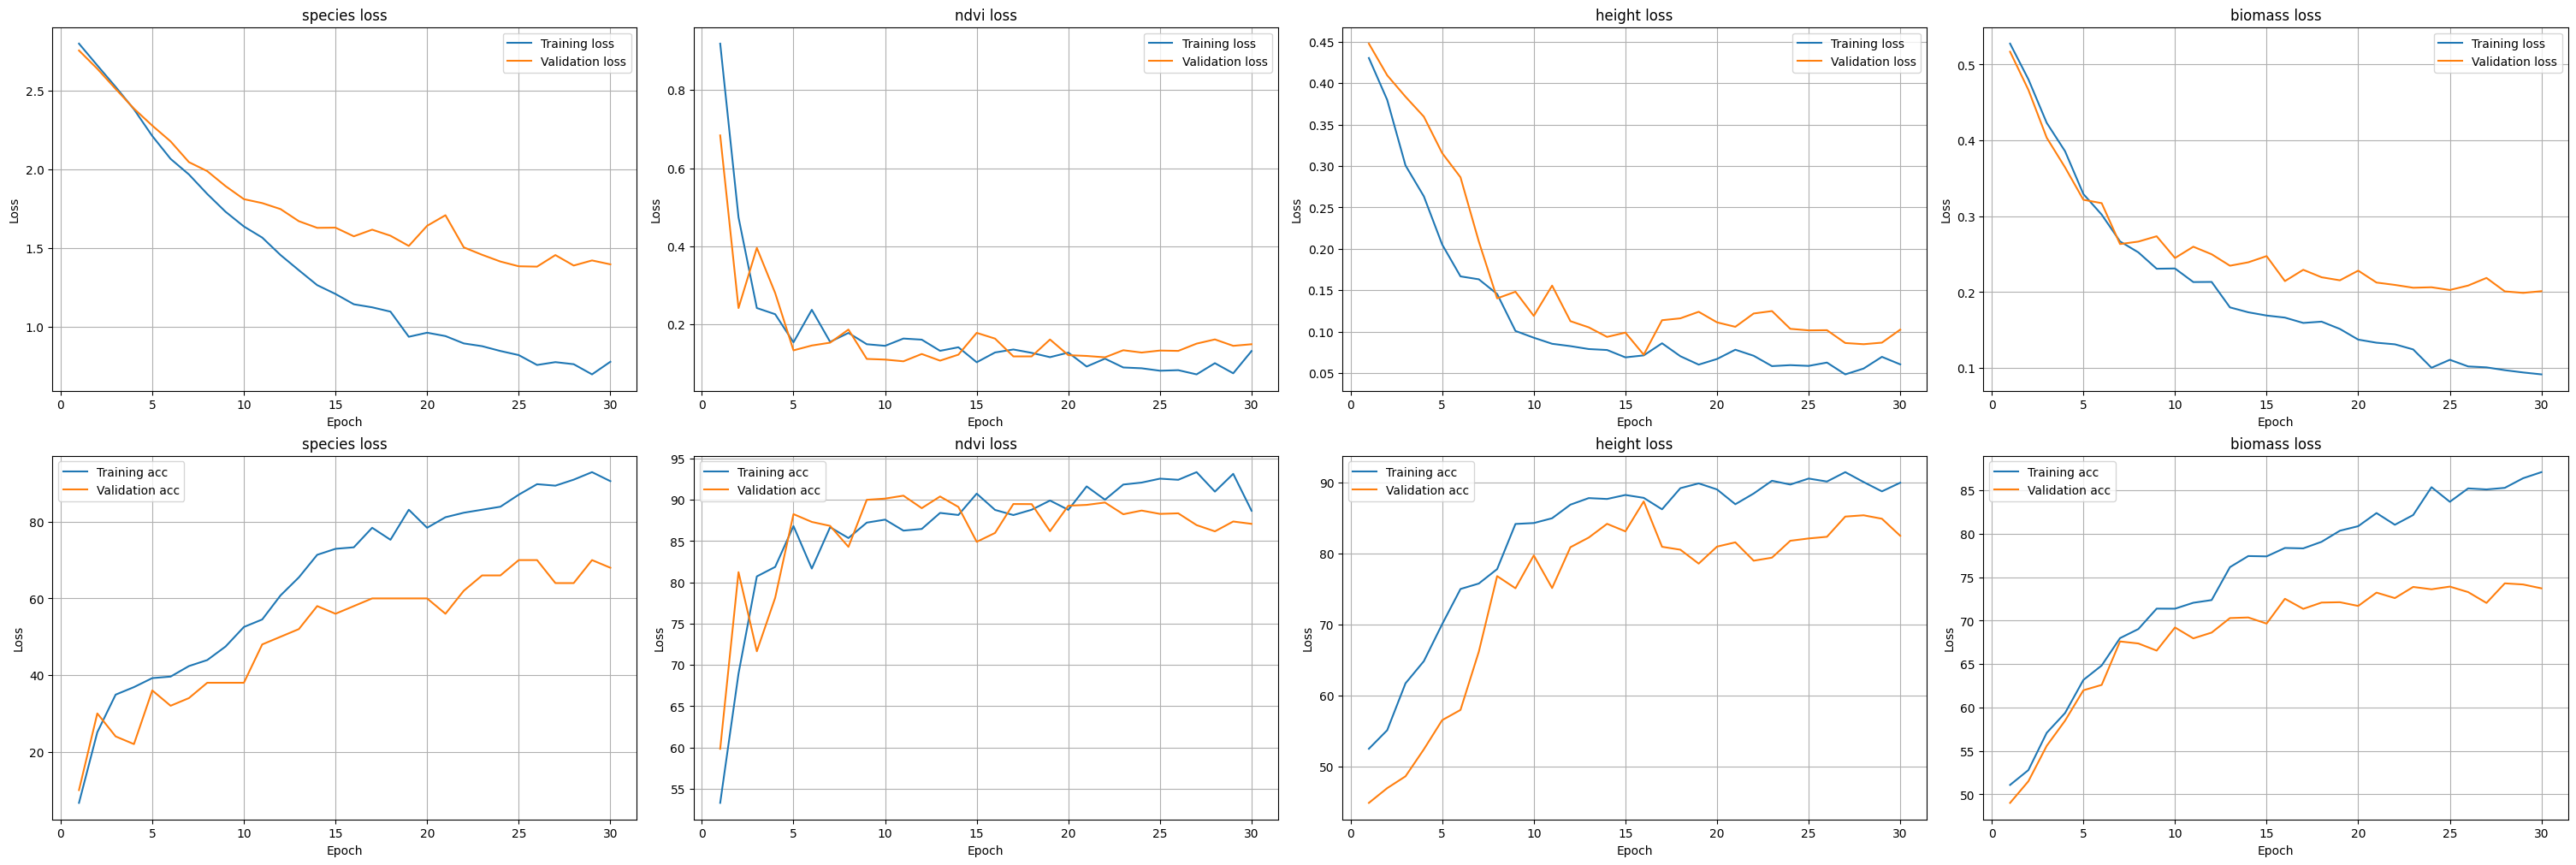

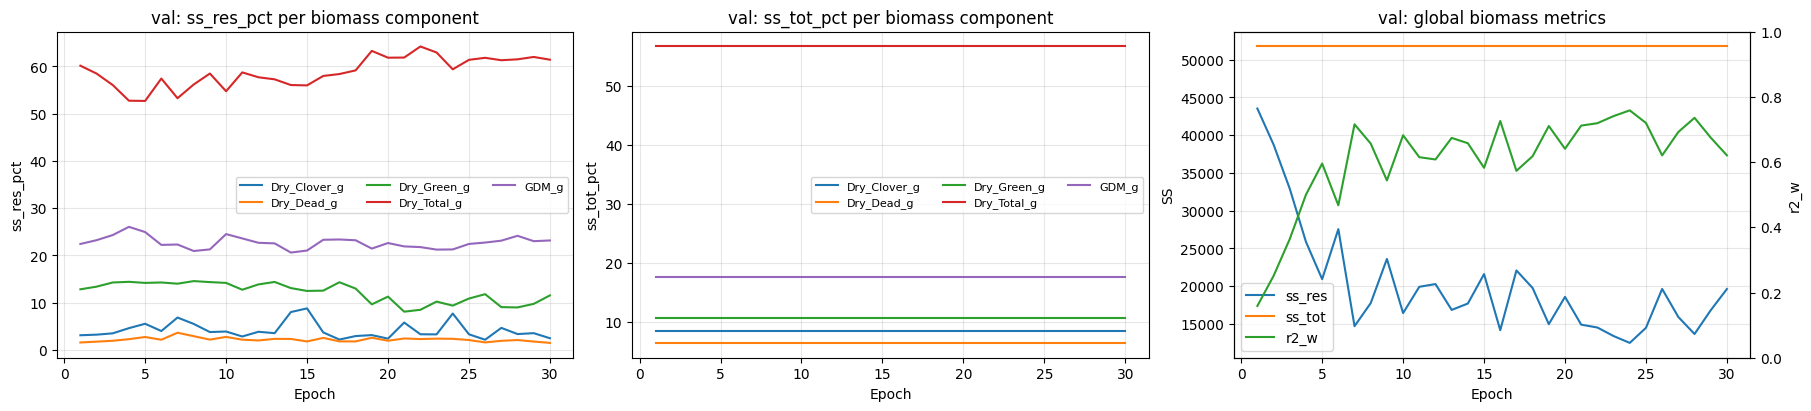

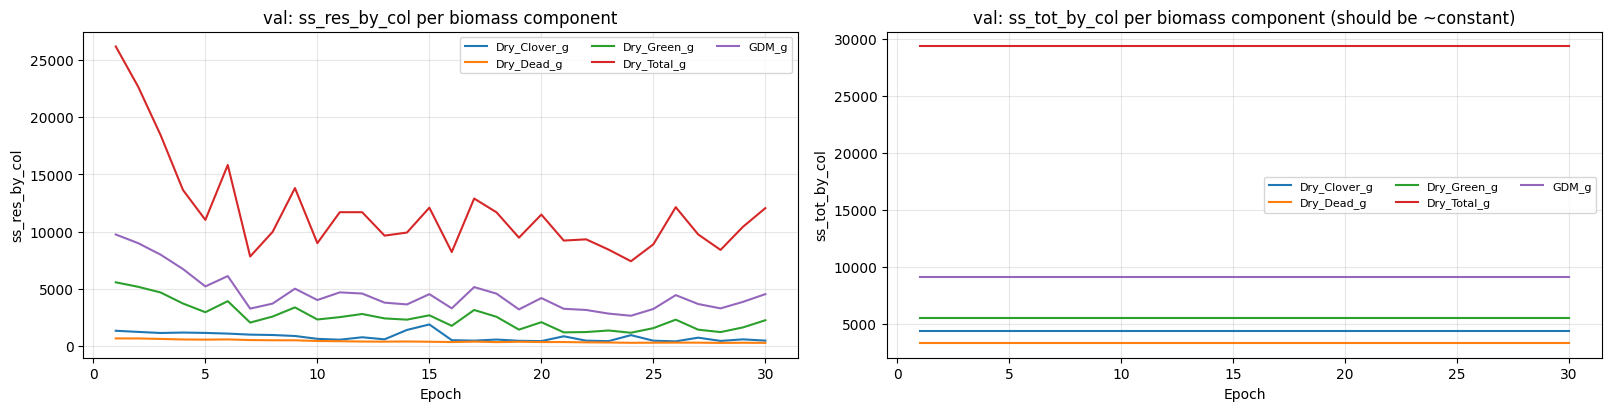

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'val: ss_res_by_col per biomass component'}, xlabel='Epoch', ylabel='ss_res_by_col'>,
        <Axes: title={'center': 'val: ss_tot_by_col per biomass component (should be ~constant)'}, xlabel='Epoch', ylabel='ss_tot_by_col'>],
       dtype=object))

In [ ]:
plot_part_metrics(history)

plot_biomass_row(history, split_name="val")
plot_biomass_abs_ss_per_ingredient(history, split_name="val", per_sample=False)



In [ ]:
plot_part_metrics(history)

plot_biomass_row(history, split_name="val")
plot_biomass_abs_ss_per_ingredient(history, split_name="val", per_sample=False)



In [ ]:
state = train_dl.dataset.get_state()
stats = state["stats"]
tail_q = state["tail_q"]
species2id = state["species2id"]


test_losses, test_accs =  eval_one_epoch(img2bm_model, eval_dl=test_dl, stats=stats, device=device)

out = compute_biomass_r2_components_raw_with_breakdown(img2bm_model, test_dl, device, state)

print(f"test_losses: {test_losses}, test_accs: {test_accs}")

print(f"\nss_res={out['ss_res']:.6f}  ss_tot={out['ss_tot']:.6f}  r2_w={out['r2_w']:.6f}")

ssr_pct = out["breakdown"]["ss_res_pct"]
sst_pct = out["breakdown"]["ss_tot_pct"]

print("Percent contribution:")
print("          " + "  ".join([f"{c:>12s}" for c in cols[2:]]))
print("ss_res% : " + "  ".join([f"{v:12.2f}" for v in ssr_pct]))
print("ss_tot% : " + "  ".join([f"{v:12.2f}" for v in sst_pct]))


test_losses: {'species': 1.5437843495724248, 'ndvi': 0.11228826956129541, 'height': 0.12627270876192578, 'biomass': 0.22642899085493648}, test_accs: {'species': 0.6470588276199266, 'ndvi': 0.9009024699529012, 'height': 0.7658621516882205, 'biomass': 0.6945895131896523}

ss_res=19363.210802  ss_tot=49701.958312  r2_w=0.610414
Percent contribution:
          Dry_Clover_g    Dry_Dead_g   Dry_Green_g   Dry_Total_g         GDM_g
ss_res% :         0.74          2.28         13.63         61.88         21.47
ss_tot% :         9.22          7.96          9.42         54.75         18.65


In [ ]:
from datetime import date
import torch

fname = f"/kaggle/working/csiro_multitask_ckpt.pt"

ckpt = {
    "model_state": img2bm_model.state_dict(),
    "state": state,
}

torch.save(ckpt, fname)
print("Saved:", fname)


Saved: /kaggle/working/csiro_multitask_ckpt_2025-12-20.pt
